In [ ]:
import pandas as pd
import numpy as np
from copy import copy, deepcopy

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

import seaborn as sns

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
df_full = pd.read_csv('data3.csv', index_col=0)
# label_cols = [c for c in df_full.columns if 'genre_' in c]
label_cols = ['genre_' + g for g in ['black', 'death', 'doom', 'folk', 'heavy', 'power', 'progressive', 'thrash']]
df_full['genre_other'] = (df_full[label_cols].sum(axis=1) == 0).astype(int)
label_cols.append('genre_other')
feature_cols = [c for c in df_full.columns if 'genre_' not in c]
genres = [c.replace('genre_', '') for c in label_cols]
print('genres: ', genres)

In [ ]:
words = set()
for label_col in label_cols:
    corr = df_full[feature_cols].apply(lambda x: x.corr(df_full[label_col]))
#     corr = corr[corr.abs().argsort()][len(corr) // 2:].sort_values()
    corr_words = corr.index[corr.abs() > 3 * corr.abs().mean()]
    words.update(set(corr_words))
feature_cols_r = sorted(words)

In [ ]:
len(feature_cols_r), len(feature_cols)

In [ ]:
class StackedModel:
    def __init__(self, base_models, final_model):
        self.base_models = base_models
        self.final_model = final_model

    @property
    def model_names(self):
        return [type(m).__name__ for m in self.base_models]

    def fit(self, X, y, **kwargs):
        n_splits = kwargs.get('n_splits', 5)
        random_state = kwargs.get('random_state', 0)
        folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        S = np.zeros((len(y), len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_idx, val_idx in folds.split(X, y):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                if self.model_names[i] == 'Sequential':
                    model.fit(X_train, y_train, validation_data=(X_val, y_val), **kwargs)
                else:
                    model.fit(X_train, y_train, **kwargs)
                y_prob = model.predict_proba(X_val)
                S[val_idx, i] = y_prob[:, y_prob.shape[1] - 1]
        S = S.mean(axis=1).reshape(-1, 1)
        self.final_model.fit(S, y)

    def predict(self, X):
        S = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            y_prob = model.predict_proba(X)
            S[:, i] = y_prob[:, y_prob.shape[1] - 1]
        S = S.mean(axis=1).reshape(-1, 1)
        y = self.final_model.predict(S)
        return y

    def predict_proba(self, X):
        S = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            y_prob = model.predict_proba(X)
            S[:, i] = y_prob[:, y_prob.shape[1] - 1]
        S = S.mean(axis=1).reshape(-1, 1)
        y = self.final_model.predict_proba(S)
        return y

In [243]:
class BinaryRelevance:
    def __init__(self, estimator, features, labels, oversampler=None):
        self.estimator = estimator
        self.features = features
        self.labels = labels
        self.estimators_ = {}
        self.oversampler = oversampler

    def fit(self, df_train, **kwargs):
        X_train = df_train[self.features].values
        models = {}
        for label in self.labels:
            print('training binary classifier for label: ' + label)
            y_train = df_train[label].values
            if self.oversampler:
                X_train_resample, y_train_resample = self.oversampler.fit_resample(X_train, y_train)
            else:
                X_train_resample, y_train_resample = X_train, y_train
            model = deepcopy(self.estimator)
            model.fit(X_train_resample, y_train_resample, **kwargs)
            models[label] = model
        self.estimators_ = models

    def predict(self, df_test):
        X_test = df_test[self.features].values
        df_pred = pd.DataFrame(index=df_test.index, columns=self.labels)
        df_prob = pd.DataFrame(index=df_test.index, columns=self.labels)
        for label in self.labels:
            model = self.estimators_[label]
            y_prob = model.predict_proba(X_test)
            df_prob[label] = y_prob[:, y_prob.shape[1] - 1]
        df_prob = df_prob.div(df_prob.sum(axis=1), axis=0)
        thresh = 1. / len(self.labels)
        for i, row in df_prob.iterrows():
            df_pred.loc[i] = (row >= thresh).astype(int)
        return df_pred, df_prob

In [244]:
def plot_history(history):
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return fig

In [245]:
nn_model = Sequential()
nn_model.add(Dense(10, input_dim=len(feature_cols_r), activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rf_params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
rf_model = RandomForestClassifier(n_jobs=-1, random_state=0, **rf_params)

lr_model = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=0)
nb_model = GaussianNB()

In [246]:
stacked_model = StackedModel(
    base_models=[
        nn_model,
#         lr_model
#         nb_model
    ],
    final_model=LogisticRegression(solver='lbfgs', random_state=0)
)

In [247]:
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
df_train, df_test = train_test_split(df_norm, test_size=0.2, random_state=0)
br = BinaryRelevance(
    stacked_model,
    feature_cols_r,
    label_cols,
    oversampler=RandomOverSampler(random_state=0)
)
br.fit(df_train, epochs=5, verbose=False, batch_size=10)
df_pred, df_prob, df_true = br.predict(df_test)
for label in label_cols:
    print("{}: {:.4f}".format(label.replace('genre_', ''), balanced_accuracy_score(df_true[label], df_pred[label])))

training binary classifier for label: genre_black
training binary classifier for label: genre_death
training binary classifier for label: genre_doom
training binary classifier for label: genre_folk
training binary classifier for label: genre_heavy
training binary classifier for label: genre_power
training binary classifier for label: genre_progressive
training binary classifier for label: genre_thrash
training binary classifier for label: genre_other


ValueError: not enough values to unpack (expected 3, got 2)

In [248]:
df_pred, df_prob = br.predict(df_test)
df_true = df_test[label_cols]
for label in label_cols:
    print("{}: {:.4f}".format(label.replace('genre_', ''), balanced_accuracy_score(df_true[label], df_pred[label])))

black: 0.7758
death: 0.7400
doom: 0.6988
folk: 0.8646
heavy: 0.7997
power: 0.8713
progressive: 0.7575
thrash: 0.7247
other: 0.7519


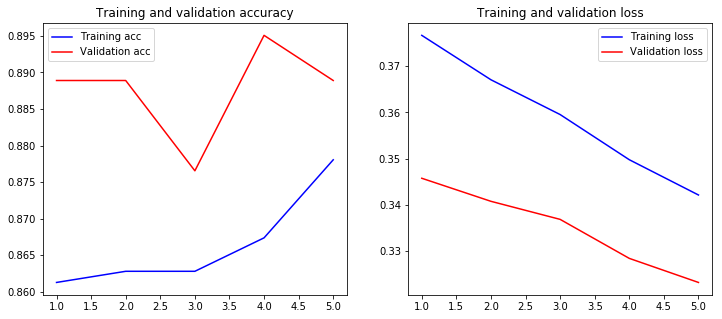

In [249]:
for base_model in br.estimators_['genre_black'].base_models:
    model_name = type(base_model).__name__
    if model_name == 'Sequential':
        plot_history(base_model.history)
    elif model_name == 'RandomForest':
        feature_importances = base_model.feature_importances_
        sort_idx = feature_importances.argsort()[:-10:-1]
        plt.bar(np.array(feature_cols_r)[sort_idx], feature_importances[sort_idx])
        plt.xticks(rotation=45, ha='right')
        plt.show()

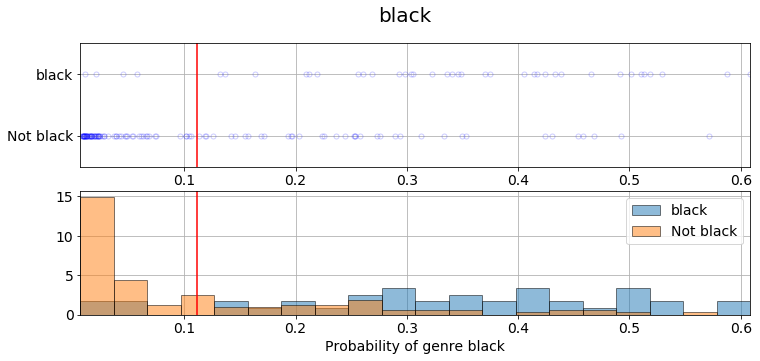

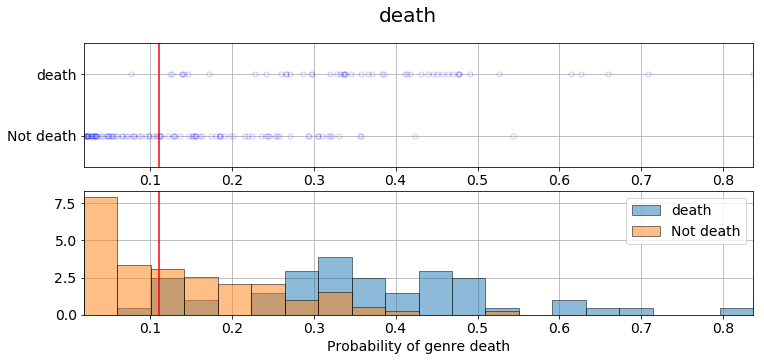

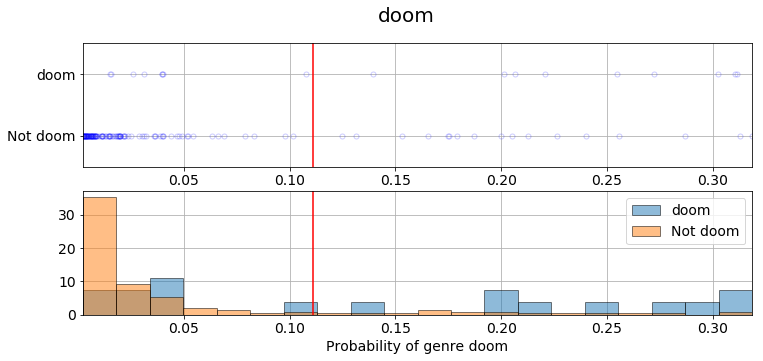

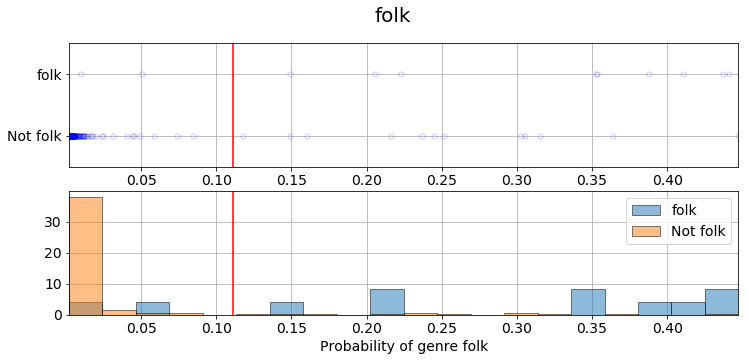

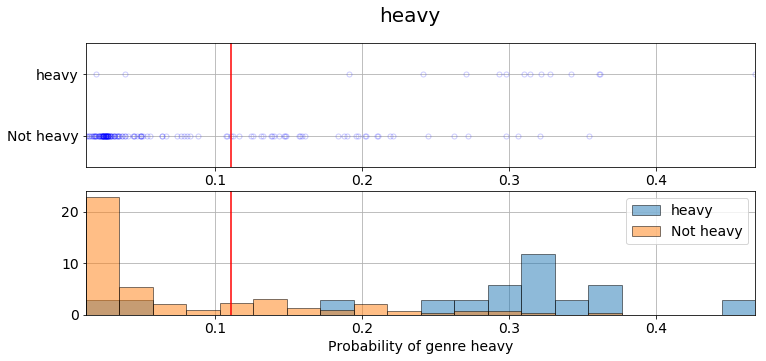

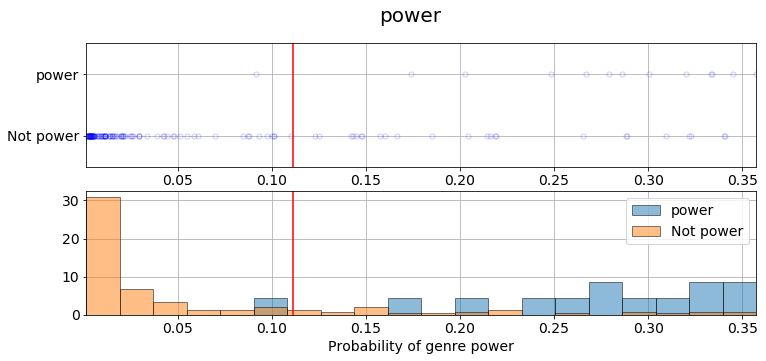

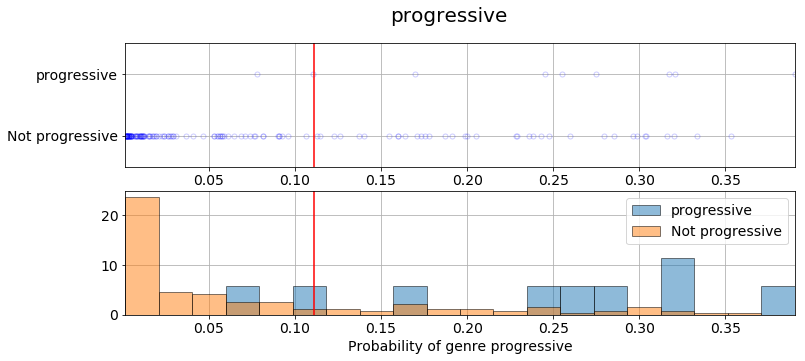

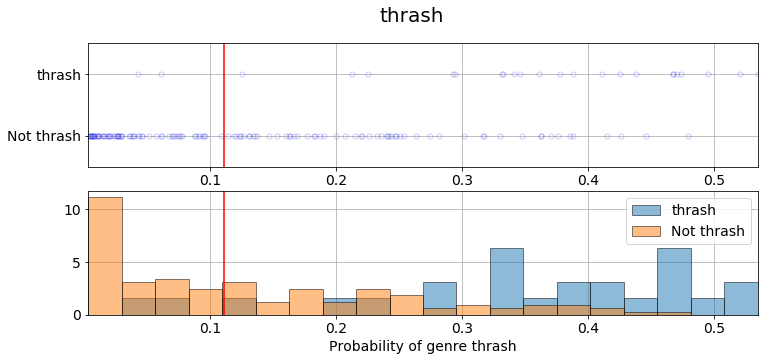

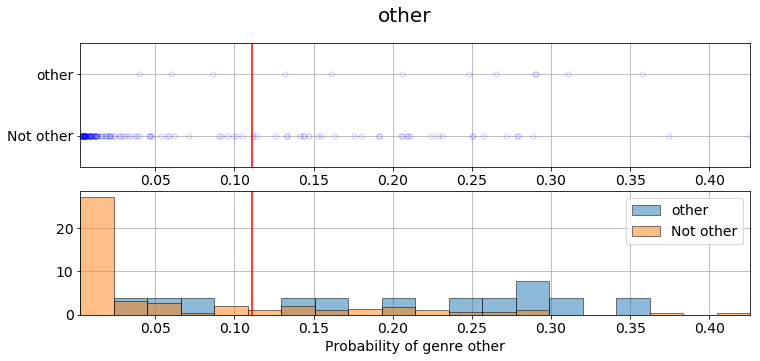

In [250]:
for label in df_pred.columns:
    genre = label.replace('genre_', '')
    y_prob = df_prob[label]
    y_true = df_true[label]
    plt.figure(figsize=(12, 5))
    plt.suptitle(genre, fontsize=20)
    plt.subplot(2, 1, 1)
    plt.plot(y_prob, y_true, 'o', markersize=5, markerfacecolor='none', markeredgecolor='b', alpha=0.2)
    plt.axvline(1 / len(df_pred.columns), color='r')
    plt.xlim(y_prob.min(), y_prob.max())
    plt.ylim(-0.5, 1.5)
    plt.tick_params(labelsize=14)
    plt.yticks([0, 1], ["Not " + genre, genre])
    plt.grid()
    plt.subplot(2, 1, 2)
    bins = np.linspace(y_prob.min(), y_prob.max(), 21)
    plt.hist(y_prob[y_true == 1], bins=bins, alpha=0.5, edgecolor='k', label=genre, density=True)
    plt.hist(y_prob[y_true == 0], bins=bins, alpha=0.5, edgecolor='k', label='Not ' + genre, density=True)
    plt.axvline(1 / len(df_pred.columns), color='r')
    plt.xlim(y_prob.min(), y_prob.max())
    plt.tick_params(labelsize=14)
    plt.xlabel("Probability of genre " + genre, fontsize=14)
    plt.grid()
    plt.gca().set_axisbelow(True)
    plt.legend(fontsize=14)
    plt.show()

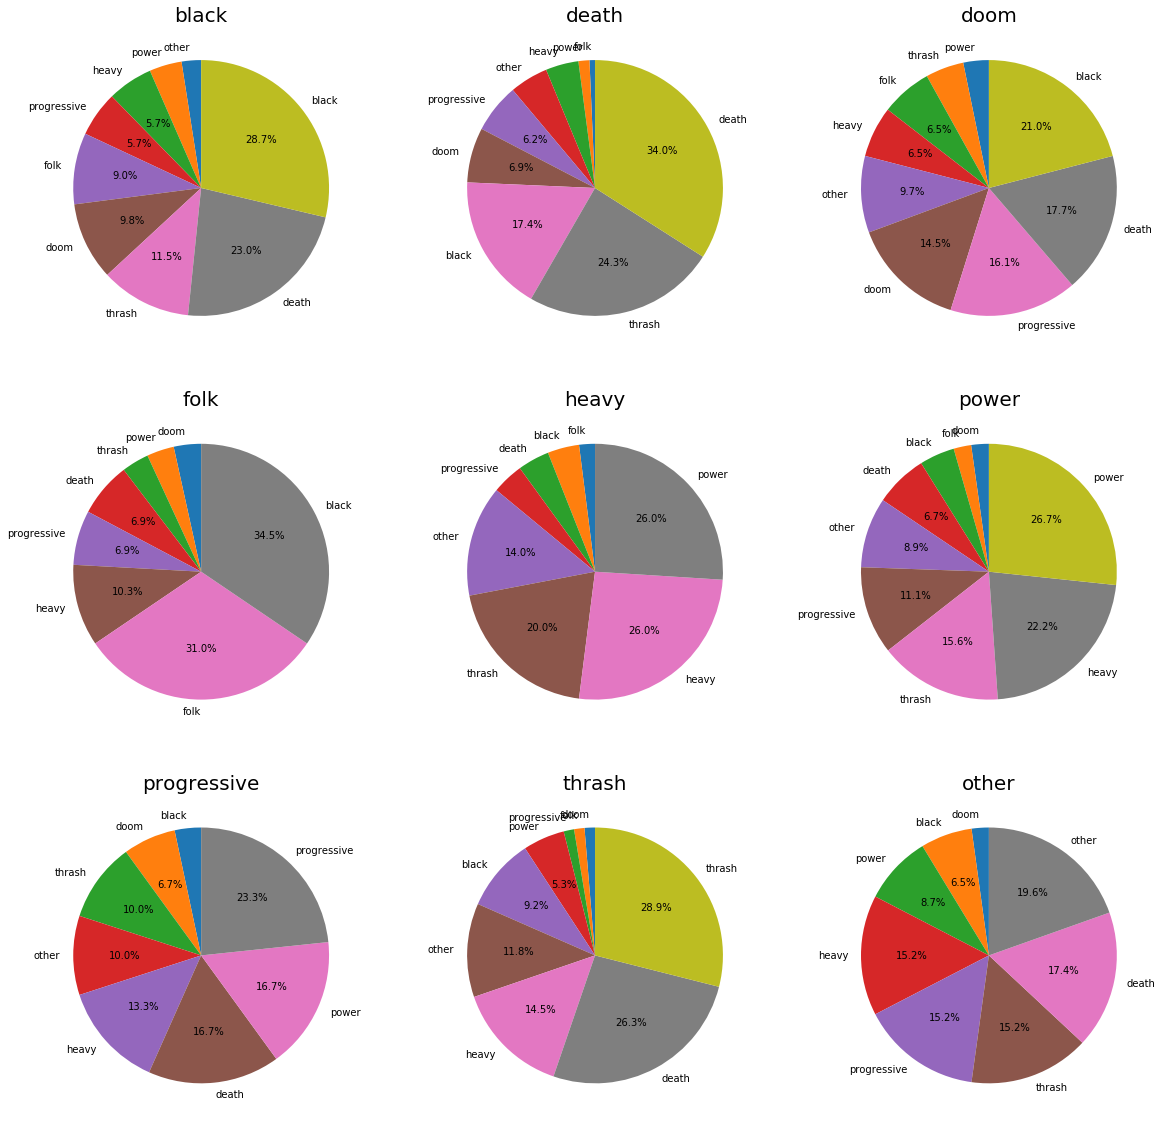

In [310]:
fig, ax = plt.subplots(3, np.ceil(len(label_cols) / 3).astype(int), figsize=(20, 20))
def autopct(pct):
    return ('{:.1f}%'.format(pct) if pct > 5 else '')
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        label = label_cols[i * ax.shape[1] + j]
        pie_data = df_pred[df_true[label].astype(bool)].sum(axis=0).sort_values()
        pie_data = pie_data[pie_data > 0]
        labels = [n.replace('genre_', '') if v > 0.05 else '' for n, v in pie_data.items()]
        ax[i, j].pie(pie_data.values, labels=labels, autopct=autopct, startangle=90)
        ax[i, j].set_title(label.replace('genre_', ''), size=20)
plt.show()

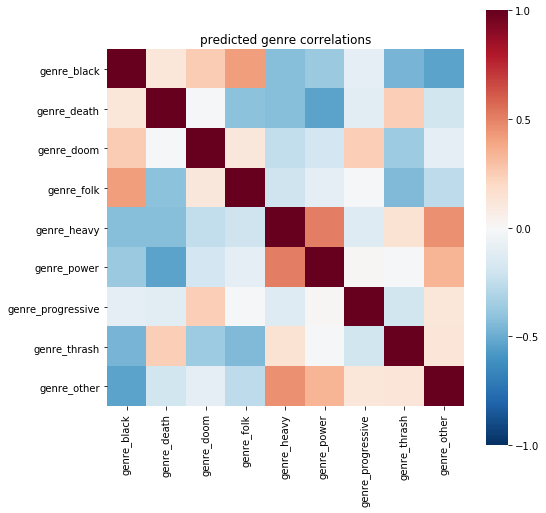

In [252]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_pred.corr(), square=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(-1, 1, 5))
plt.title('predicted genre correlations')
plt.show()

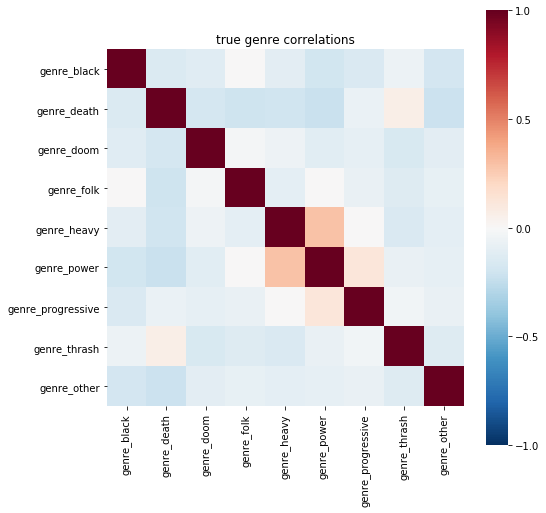

In [253]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_true.corr(), square=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(-1, 1, 5))
plt.title('true genre correlations')
plt.show()

enter some song lyrics:  I've seen the words you are not to know Of legends untold I've seen the truths of the outer world Of mysteries unfold  And through the darkness of Lucifer I'll find my way Because in darkness I see the light


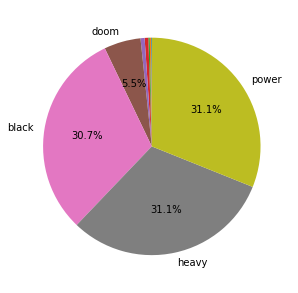

In [365]:
import pickle as pkl

vectorizer = pkl.load(open('vectorizer.pkl', 'rb'))
example = [
    input('enter some song lyrics: ')
]
example_df = pd.DataFrame(vectorizer.transform(example).toarray(), columns=vectorizer.vocabulary)
example_pred, example_prob = br.predict(example_df)
pie_data = example_prob.loc[0].sort_values()
def autopct(pct):
    return ('{:.1f}%'.format(pct) if pct > 5 else '')
labels = [n.replace('genre_', '') if v > 0.05 else '' for n, v in pie_data.items()]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.pie(pie_data.values, labels=labels, autopct=autopct, startangle=90)
# ax.set_title(example[0], size=20)
plt.show()